# Chapter 9: Global Optimization (GO) and Mixed-variable Problems

In the previous chapters we saw that local optimization methods can efficiently find local minima of continuous and differentiable functions. However, many real-world optimization problems are non-convex and may contain multiple local minima, discontinuities, or mixed-variable types (continuous, integer, categorical). In such cases, local methods may fail to find the global optimum.

There are several reasons why global optimization might be necessary:

- The objective function may have multiple local minima, and we want to find the absolute best solution.
- The problem may involve discrete or categorical variables that cannot be handled by gradient-based methods.
- We want to find all the roots of a system of equations, which may require exploring the entire solution space.
- We want to explore the solution space for sensitivity analysis or uncertainty quantification.

One of the first examples of historical problems that require global optimization was finding all roots of the cubic equation. This was first achieved by finding a general analytical solution of the cubic roots, but it would take centuries before a general numerical method was found that was guaranteed to enumerate all roots. The roots of the cubic equation often have physical meaning such as in thermodynamics where they can represent different phases of a substance. Local methods may only find one root, while global methods can identify all possible roots.

## Introduction and motivation for  GO
#### Demonstration of VdW Cubic Equation Roots Using Local vs Global Methods

The van der Waals (VdW) equation models real gas behavior and leads to a cubic equation in molar volume \(V\):

$$
P V^3 - (P b + R T) V^2 + a V - a b = 0
$$

where $P$ is pressure, $T$ is temperature, $R$ is the gas constant, and $a, b$ are VdW constants (e.g., for CO₂: $a = 3.59$, $b = 0.0427$).

For certain $P, T$, there are three real roots corresponding to liquid, unstable, and gas phases.

First, let's solve it as a polynomial using NumPy's `roots` for all exact roots (special case for cubics).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (for CO2 at subcritical conditions)
P = 50  # atm
T = 280  # K
R = 0.0821  # L atm / mol K
a = 3.59  # L² atm / mol²
b = 0.0427  # L / mol

# Cubic coefficients: V^3 + c2 V^2 + c1 V + c0 = 0
c3 = P
c2 = -(P * b + R * T)
c1 = a
c0 = -a * b

# Find all roots using np.roots
roots_poly = np.roots([c3, c2, c1, c0])
print("All roots (polynomial method):", roots_poly)

# Plot the cubic to show roots
def vdwaals_cubic(V):
    return P * V**3 + c2 * V**2 + c1 * V + c0

V_plot = np.linspace(0.03, 0.5, 1000)
plt.plot(V_plot, vdwaals_cubic(V_plot))
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Molar Volume V (L/mol)')
plt.ylabel('Cubic Residual')
plt.title('VdW Cubic Equation with Three Real Roots')
plt.grid(True)
plt.show()

This polynomial method finds all roots exactly but is limited to low-degree polynomials. For general non-polynomial functions in engineering (e.g., transcendental equations from orbital mechanics or chemical kinetics), we need broader global methods.
Local methods like fsolve depend on initial guesses and may miss roots:

In [ ]:
from scipy.optimize import fsolve

# Local solve from different starting points
root1 = fsolve(vdwaals_cubic, x0=0.05)
root2 = fsolve(vdwaals_cubic, x0=0.1)
root3 = fsolve(vdwaals_cubic, x0=0.3)
print("Local roots (fsolve):", root1, root2, root3)  # May converge to same or different based on x0

In complex engineering problems, such as optimizing satellite trajectories under gravitational perturbations (involving non-polynomial trig functions) or designing heat exchangers with phase changes (nonlinear constraints), local methods fail if the landscape is multimodal. Global methods systematically explore to avoid this.
To find all roots globally for the VdW cubic (or general functions), we can use SHGO from SciPy on the squared residual (f(V)^2) to find all local minima where the value is zero (roots).

In [ ]:
from scipy.optimize import shgo

# Objective: minimize (cubic)^2 to find zeros
def objective(V):
    return vdwaals_cubic(V)**2

bounds = [(0.03, 0.5)]  # Feasible volume range
res_shgo = shgo(objective, bounds, n=100, iters=3)  # Sample points and iterations for refinement

# Extract unique roots where fun ≈ 0
roots_global = res_shgo.xl[np.where(np.isclose(res_shgo.funl, 0, atol=1e-10))]
print("Global roots (SHGO on squared residual):", roots_global.flatten())

This approach generalizes to non-polynomial problems, ensuring all physically meaningful solutions are found. For non-polynomial engineering problems (e.g., chaotic dynamics or orbital optimization), general global methods are essential. Challenges include the "no free lunch" theorem: no single method excels universally, and computational cost scales with dimensionality. Methods balance exploration (searching broadly) and exploitation (refining promising areas).

This chapter focuses on essential global methods available in SciPy, grouped by shared principles (deterministic vs. stochastic). We prioritize derivative-free/black-box approaches, as gradients may be unavailable or unreliable. Optional subsections provide depth but can be skipped in lectures.

#### Ackley Benchmark Function
Throughout this chapter, we frequently use the Ackley function as a benchmark for testing global optimization methods. The Ackley function is a widely used multimodal test function for evaluating the performance of optimization algorithms, particularly in handling multiple local minima and a broad search space. It is defined as:

$$f(x, y) = -20 \exp\left(-0.2 \sqrt{0.5(x^2 + y^2)}\right) - \exp\left(0.5(\cos(2\pi x) + \cos(2\pi y))\right) + 20 + e$$

The function has a global minimum of $f(0, 0) = 0$ at $(x, y) = (0, 0)$, surrounded by many local minima that challenge algorithms to escape and find the global optimum. It is typically evaluated over domains like $[-5, 5] \times [-5, 5]$ or larger.

To visualize its multimodal landscape, below is a 3D surface plot:

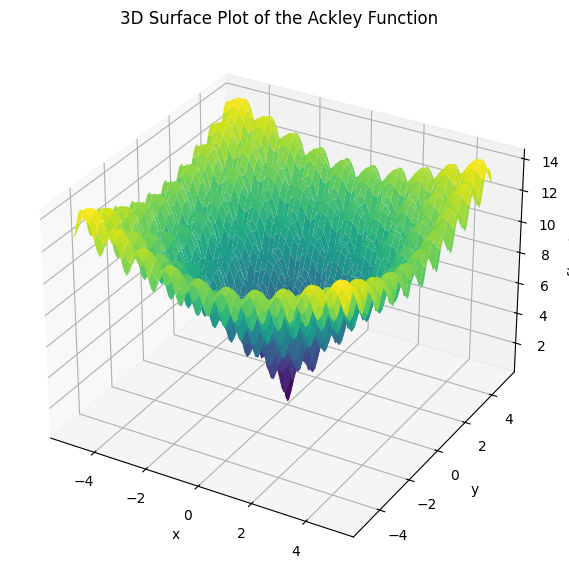

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def ackley(x, y):
    a, b, c = 20, 0.2, 2 * np.pi
    sum_sq = 0.5 * (x**2 + y**2)
    sum_cos = 0.5 * (np.cos(c * x) + np.cos(c * y))
    return -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(sum_cos) + a + np.exp(1)

# Generate grid
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = ackley(X, Y)

# 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('3D Surface Plot of the Ackley Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.show()

This function demonstrates the challenges of global optimization, with many local minima surrounding the global minimum at the center. It serves as a standard test case for evaluating the effectiveness of various global optimization algorithms discussed in this chapter.

## 9.1 Multi-start methods
Multi-start methods are a simple heuristic approach to global optimization, bridging local and global techniques. They involve running a local optimizer (e.g., from Chapters 7–8, like BFGS or SQP) multiple times from randomly sampled initial points within the feasible domain $\mathcal{X}$. This increases the probability of discovering the global minimum by exploring different basins of attraction, especially in multimodal problems. Multi-start is easy to implement and can leverage efficient local solvers making it a practical choice for many applications, especially when good starting points are known.

However, multi-start does not guarantee finding the global optimum—it lacks certificates of optimality and can be inefficient, as it may redundantly converge to the same local minima. True global methods (covered in later sections) systematically partition or sample the space for exhaustiveness or probabilistic guarantees. Use multi-start for quick approximations when computational budget is limited or as a baseline before advanced methods.

The trade-offs of multi-start methods in short include:

- Advantages: Easy to implement; parallelizable; leverages efficient local solvers.
- Disadvantages: No convergence guarantees; scales poorly with dimensions (requires many starts); wasteful if basins are uneven.

> #### Example: Multi-start on a Multimodal Function
> Consider the problem of finding the global minimum of the multimodal function $f(x) = x^2 + 30 \sin(x)$ over $\mathcal{X} = [-10, 10]$, with multiple minima.


In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def objective(x):
    return x**2 + 30 * np.sin(x)

# Plot to visualize
x = np.linspace(-10, 10, 1000)
plt.plot(x, objective(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Multimodal Function')
plt.show()

# Multi-start: 10 random starts
bounds = (-10, 10)
results = []
for _ in range(10):
    x0 = np.random.uniform(*bounds)
    res = minimize(objective, x0, method='BFGS')
    results.append((res.x[0], res.fun))

# Best result
best_x, best_f = min(results, key=lambda r: r[1])
print(f"Best minimum found: x={best_x:.2f}, f={best_f:.2f}")


## 9.2 Deterministic Methods in SciPy
Deterministic global optimization methods provide reproducible results without randomness, often guaranteeing convergence to the global optimum (or all minima) under certain conditions, such as bounded domains. Unlike stochastic methods (Section 9.3), they systematically explore the search space through partitioning, bounding, or surrogate modeling, making them suitable for problems where reliability is critical, like spacecraft design optimization or root-finding in thermodynamic models. However, they can be computationally expensive in high dimensions due to the "curse of dimensionality."

Many deterministic methods assume Lipschitz continuity to bound function behavior (from Chapter 7):

> **Defintion:**
> **Lipschitz Continuity**: A function $f: \mathbb{R}^n \to \mathbb{R}$ (or its gradient $\nabla f$) is Lipschitz continuous with constant $L > 0$ if, for all $\mathbf{x}, \mathbf{y}$ in the domain,
>
> $$\| f(\mathbf{x}) - f(\mathbf{y}) \| \leq L \| \mathbf{x} - \mathbf{y} \|.$$
>
> For gradients, this applies to $\| \nabla f(\mathbf{x}) - \nabla f(\mathbf{y}) \| \leq L \| \mathbf{x} - \mathbf{y} \|$ (Lipschitz gradient). This bounds how fast the function changes, ensuring step sizes like $\alpha < 1/L$ lead to convergence in GD.

 The Liptschitz constant $L$ limits how steeply the function changes in a subdomain, allowing safe elimination of subdomains $\Omega \in \mathcal{X}$ without evaluating everywhere (e.g., if a subregion's lower bound exceeds a known minimum, prune it). Many numerical methods expoit this property for efficient global exploration by eliminating subdomains that cannot contain the global minimum.

SciPy implements several such methods, focusing on derivative-free (black-box) scenarios common in engineering simulations.


### 9.2.1 DIRECT (Dividing RECTangles)

The DIRECT algorithm, introduced by Jones et al. in 1993, is a deterministic global optimization method that systematically partitions the search domain into hyperrectangles (intervals in 1D, rectangles in 2D, etc.) to explore the objective function without requiring derivatives or prior knowledge of the Lipschitz constant $  L  $. It balances global exploration (sampling large, uncertain regions) and local exploitation (refining promising small regions) by selecting "potentially optimal" subregions—those that could contain the global minimum assuming various possible values of $  L  $.

Unlike methods that estimate $  L  $ explicitly, DIRECT implicitly considers a range of $  L  $ values. For each hyperrectangle, it evaluates the objective at the center and uses the rectangle's size and center value to determine if it might hold the minimum. Large rectangles with low center values are prioritized for global search, while small ones with low values drive local refinement. This avoids getting stuck in local minima and guarantees convergence to the global minimum in the limit (as iterations increase), provided the function is continuous and the domain is bounded.

To understand the mechanics, we start with the 1D case, where the domain is an interval $  [a, b]  $. Here, "hyperrectangles" are subintervals, and partitioning divides them into thirds (to maintain balance). The key innovation is the selection step: for each subinterval $  i  $ with length $  d_i  $, center $  c_i  $, and function value $  f(c_i)  $, DIRECT imagines drawing lines from $  f(c_i)  $ with slopes $  \pm K  $ (where $  K  $ approximates $  L  $), representing the steepest possible descent/ascent within the Lipschitz bound. The potential lower bound in the interval is then $  f(c_i) - K \cdot (d_i / 2)  $. An interval is "potentially optimal" if there exists some $  K > 0  $ such that this lower bound is the lowest among all intervals, and it improves over the current best by at least a small $  \epsilon  $ (e.g., $  \epsilon = 10^{-4} \cdot |f_{\text{best}}|  $).
Geometrically, this corresponds to plotting points $  (d_i / 2, f(c_i))  $ for all intervals and selecting those on the lower-right convex hull—these are optimal for different $  K  $ (steeper slopes favor smaller intervals for local search, shallower slopes favor larger ones for global search).
Pseudo Code for DIRECT (1D Version)
Here is a simplified pseudo code for the 1D case, focusing on the main loop:

```python
Initialize:
  Normalize domain to [0, 1] for simplicity (scale actual bounds).
  Set initial interval: I_1 = [0, 1], c_1 = 0.5, evaluate f(c_1).
  Add to list of intervals.
  Set f_best = f(c_1), x_best = c_1.
  Set iteration counter = 1.

While (budget not exceeded, e.g., max evaluations or tolerance):
  # Selection: Identify potentially optimal intervals
  potentially_optimal = []
  For each interval i with (d_i, f(c_i)):
    Compute potential lower bound for a range of K (or use convex hull method):
      Sort intervals by increasing d_i.
      Compute lower hull: points where no other point j has lower f - K*(d/2) for some K.
      (Practically: Plot (d_i/2, f(c_i)), find lower-right convex hull.)
  Add hull intervals to potentially_optimal if f(c_i) - K*(d_i/2) <= f_best - epsilon * |f_best| for some K.

  # Division: For each potentially optimal interval
  For each po_interval in potentially_optimal:
    Divide into thirds: left [a, a + d/3], center [a + d/3, a + 2d/3], right [a + 2d/3, b].
    Evaluate f at new centers: (a + d/6), (a + 5d/6). (Center interval reuses old f(c).)
    Add new intervals to list, remove old one.
    Update f_best and x_best if better value found.

  Increment iteration.
```




In higher dimensions, division cycles through coordinates (longest side first), and "size" is measured by the Euclidean norm of half-diagonals.


> #### Example in 1D: Global and Local Exploration
> To visualize, consider the multimodal function $f(x) = \sin(10x) + x$ over $[0, 2\pi]$, which has multiple local minima (global at $x \approx 5.646$). We'll simulate the first few iterations with Python code, plotting the function, subintervals, sampled points, and Lipschitz bound lines (with estimated $K$ from the hull).
The plots show:
>
> - Initial: One interval, evaluation at midpoint.
> - After Iteration 1: Division into thirds, all potentially optimal (global exploration).
> - Subsequent: Mix of large (global) and small (local) divisions, with lines showing possible descent bounds.


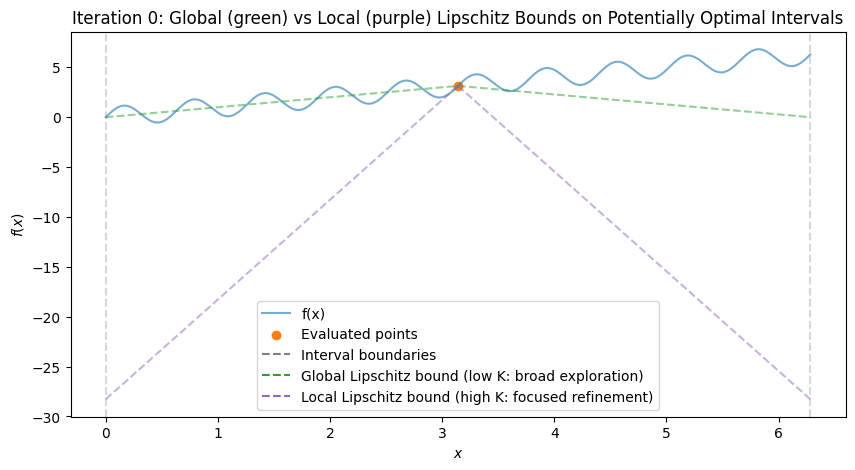

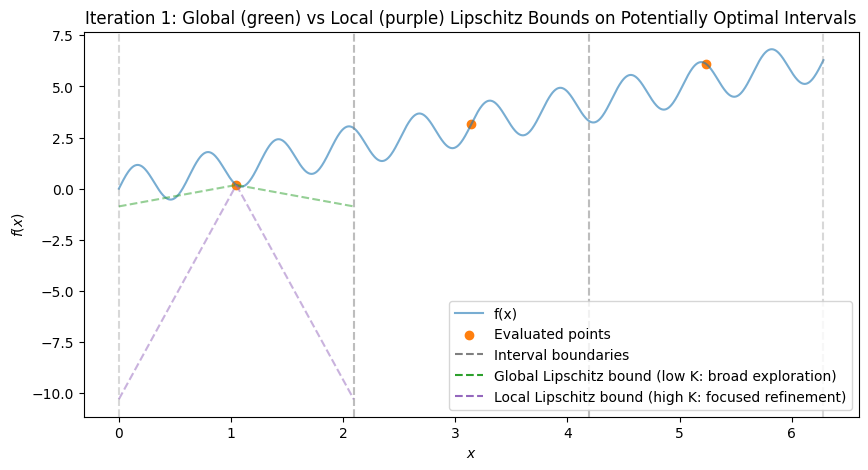

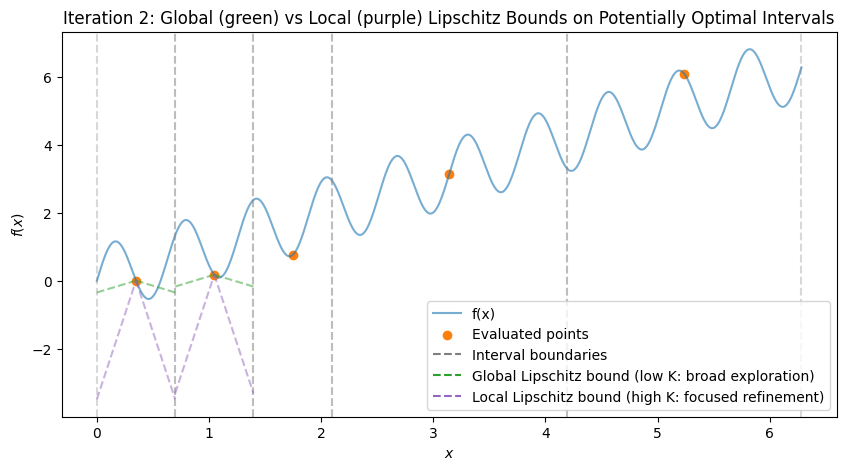

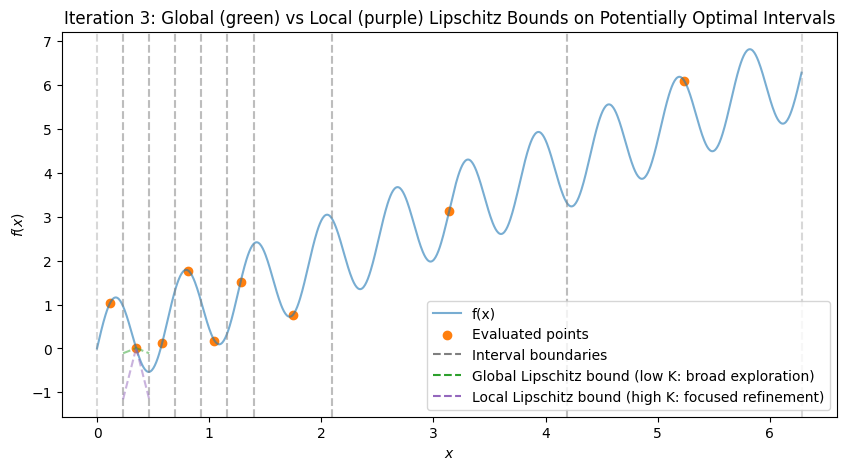

After 3 iterations, best x ≈ 0.349, f ≈ 0.007


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def objective(x):
    return np.sin(10 * x) + x

bounds = [0, 2 * np.pi]
x_plot = np.linspace(bounds[0], bounds[1], 1000)
f_plot = objective(x_plot)

# Simulate DIRECT steps (simplified 1D implementation)
class Interval:
    def __init__(self, a, b, f_c):
        self.a = a
        self.b = b
        self.c = (a + b) / 2
        self.d = b - a
        self.f_c = f_c

def select_potentially_optimal(intervals, f_best, epsilon=1e-4):
    # Simplified: Sort by d descending, check lower bound condition
    # Approximate hull by selecting intervals with best f_c - K * (d/2) for K in [0, max_possible]
    points = sorted([(i.d, i.f_c, i) for i in intervals], reverse=True)  # Large d first
    po = []
    min_f = min([i.f_c for i in intervals])
    for _, f_c, inter in points:
        # Check if potentially better (exists K where lower bound < f_best)
        if f_c - (inter.d / 2) * 1 < f_best - epsilon * abs(f_best):  # Adjusted K=1 for demo
            po.append(inter)
        if f_c <= min_f:  # Always include if equal to or better than current min
            po.append(inter)
    return list(set(po))  # Dedup

# Initial setup
intervals = [Interval(bounds[0], bounds[1], objective((bounds[0] + bounds[1]) / 2))]
f_best = intervals[0].f_c
x_best = intervals[0].c
all_points = {(intervals[0].c, f_best)}

# Function to plot state
def plot_iteration(it, intervals, all_points):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x_plot, f_plot, 'tab:blue', label='f(x)', alpha=0.6)
    for inter in intervals:
        ax.axvline(inter.a, color='tab:gray', linestyle='--', alpha=0.3)
        ax.axvline(inter.b, color='tab:gray', linestyle='--', alpha=0.3)
    ax.scatter([p[0] for p in all_points], [p[1] for p in all_points], color='tab:orange', label='Evaluated points')

    # Draw example Lipschitz lines for PO intervals (steep for local, shallow for global)
    for inter in intervals:
        if inter in po:  # Only for potentially optimal
            # Estimate K: for demo, use two values
            k_global = 1  # Shallow for global
            k_local = 10  # Steep for local
            x_left = inter.c - inter.d / 2
            x_right = inter.c + inter.d / 2
            ax.plot([x_left, inter.c], [inter.f_c - k_global * (inter.d / 2), inter.f_c], 'tab:green', linestyle='--', alpha=0.5)
            ax.plot([inter.c, x_right], [inter.f_c, inter.f_c - k_global * (inter.d / 2)], 'tab:green', linestyle='--', alpha=0.5)
            ax.plot([x_left, inter.c], [inter.f_c - k_local * (inter.d / 2), inter.f_c], 'tab:purple', linestyle='--', alpha=0.5)
            ax.plot([inter.c, x_right], [inter.f_c, inter.f_c - k_local * (inter.d / 2)], 'tab:purple', linestyle='--', alpha=0.5)

    # Add dummy lines for legend describing bounds (intervals are the dashed gray vertical lines; bounds are on PO intervals)
    ax.plot([], [], 'tab:gray', linestyle='--', label='Interval boundaries')
    ax.plot([], [], 'tab:green', linestyle='--', label='Global Lipschitz bound (low K: broad exploration)')
    ax.plot([], [], 'tab:purple', linestyle='--', label='Local Lipschitz bound (high K: focused refinement)')

    ax.set_title(f'Iteration {it}: Global (green) vs Local (purple) Lipschitz Bounds on Potentially Optimal Intervals')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.legend()
    plt.show()

# Iteration 0: Initial
po = select_potentially_optimal(intervals, f_best)
plot_iteration(0, intervals, all_points)

# Run a few iterations
max_iters = 3
for it in range(1, max_iters + 1):
    new_intervals = []
    for inter in po:
        d_third = inter.d / 3
        # Left
        a_l, b_l = inter.a, inter.a + d_third
        c_l = (a_l + b_l) / 2
        f_l = objective(c_l)
        new_intervals.append(Interval(a_l, b_l, f_l))
        all_points.add((c_l, f_l))
        # Center (reuse)
        new_intervals.append(Interval(inter.a + d_third, inter.a + 2 * d_third, inter.f_c))
        # Right
        a_r, b_r = inter.a + 2 * d_third, inter.b
        c_r = (a_r + b_r) / 2
        f_r = objective(c_r)
        new_intervals.append(Interval(a_r, b_r, f_r))
        all_points.add((c_r, f_r))

        min_val = min(f_l, f_r, inter.f_c)
        if min_val < f_best:
            f_best = min_val
            idx = np.argmin([f_l, f_r, inter.f_c])
            x_best = [c_l, c_r, inter.c][idx]

    # Update intervals: remove divided, add new
    intervals = [i for i in intervals if i not in po] + new_intervals
    po = select_potentially_optimal(intervals, f_best)
    plot_iteration(it, intervals, all_points)

print(f"After {max_iters} iterations, best x ≈ {x_best:.3f}, f ≈ {f_best:.3f}")

These plots demonstrate:

- Global Exploration: Early iterations divide large intervals (green shallow lines show broad potential descent).
- Local Exploration: Later, small intervals near minima are refined (magenta steep lines focus on local improvements).

In practice, SciPy's scipy.optimize.direct implements the full n-dimensional version efficiently.

> #### Example: Optimizing a Multimodal Function
> Consider the Ackley function, a standard multimodal benchmark: $f(x, y) = -20 \exp(-0.2 \sqrt{0.5(x^2 + y^2)}) - \exp(0.5(\cos(2\pi x) + \cos(2\pi y))) + 20 + e$, with global minimum 0 at (0,0).

In [23]:
from scipy.optimize import direct

def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    sum_sq = 0.5 * (x[0]**2 + x[1]**2)
    sum_cos = 0.5 * (np.cos(c * x[0]) + np.cos(c * x[1]))
    return -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(sum_cos) + a + np.exp(1)

bounds = [(-5, 5), (-5, 5)]
res = direct(ackley, bounds, maxiter=1000)
print(f"Global minimum: x={res.x}, f={res.fun}")

Global minimum: x=[0. 0.], f=4.440892098500626e-16


This scales to space engineering problems like optimizing orbital transfers with multimodal cost functions.




### 9.2.2 SHGO (Simplicial Homology Global Optimisation)
SHGO (Simplicial Homology Global Optimization) is a deterministic global optimization algorithm that leverages topological tools to identify all local minima in a bounded domain, thereby locating the global minimum among them. It is particularly useful for black-box, non-smooth, or noisy functions where traditional methods might miss solutions. Unlike DIRECT (which focuses on Lipschitz-based partitioning), SHGO employs simplicial triangulations: the domain is divided into simplices (triangles in 2D, tetrahedra in 3D, etc.) and finds locally convex regions using the response surface formed by function evaluations at simplex vertices.

The key innovation is using homology (from the broader field algebraic topology) to analyze the connectivity of sublevel sets $\{ \mathbf{x} \in \mathcal{X} \mid f(\mathbf{x}) \leq \alpha \}$ for decreasing $\alpha$. This detects _locally convex domains_ or clusters of potential stationary points without assuming smoothness. Once identified, local optimizers (e.g., BFGS) refine these points to find precise local minima. SHGO guarantees finding all local minima in the limit for continuous functions, making it ideal for engineering problems like finding multiple roots in thermodynamic equations (as in the VdW example) or equilibrium states in spacecraft attitude dynamics.


In more detail, SHGO starts by generating initial sample points using a low-discrepancy sequence (e.g., Sobol or the default simplicial method) to ensure uniform coverage of the bounded domain. These points are used to construct a simplicial complex—a mesh-like triangulation of the space. The algorithm then applies persistent homology to the filtration of sublevel sets, which essentially tracks how the "shape" (connected components, holes, etc.) of the function landscape changes as the threshold $\alpha$ lowers. The rank of the homology groups indicates the number of distinct basins or locally convex subdomains, each likely containing a stationary point (minimum). This topological insight allows SHGO to efficiently identify starting points for local searches without exhaustive enumeration.

Convergence is theoretically guaranteed when using the 'simplicial' sampling method, ensuring the global minimum is found in finite time for Lipschitz-continuous functions. For other sampling methods like Sobol or Halton, convergence is probabilistic but faster in practice. Compared to DIRECT, SHGO's homology-based approach is more effective for detecting multiple minima in non-convex landscapes, as it explicitly models the topological structure rather than relying solely on size-value trade-offs. This makes SHGO suitable for general nonlinear programming (NLP) and black-box optimization in low-dimensional problems (typically <10 variables), with support for inequality and equality constraints via compatible local solvers like SLSQP or COBYLA.

In SciPy, SHGO is invoked with parameters controlling sampling density (n, number of initial points per iteration) and refinement (iters, number of iterations). Higher values improve minimizer detection but increase computational cost; parallelization via workers can mitigate this for multicore systems.


```python
Initialize:
  Sample initial points using sampling sequence (low-discrepancy for uniformity) within bounds.
  Evaluate objective function $f$ at samples.

Main Loop (over iterations):
  Construct simplicial complex (triangulation) from samples.
  Compute persistent homology on sublevel filtrations to identify local minimizer candidates (vertices in distinct components).
  Refine candidates with local optimization (e.g., minimize from each).
  Add new samples in promising simplices (adaptive refinement).
  Update global minimum from refined local minima.

Return: Global min (res.x, res.fun), all local mins (res.xl, res.funl).
```

In SciPy, use `scipy.optimize.shgo(func, bounds, n=..., iters=...)`; n sets samples per iteration, iters controls refinement depth.


> #### Example: Finding All Minima in the Peaks Function
> The Peaks function $f(x, y) = 3(1-x)^2 \exp(-x^2 - (y+1)^2) - 10(x/5 - x^3 - y^5) \exp(-x^2 - y^2) - \frac{1}{3} \exp(-(x+1)^2 - y^2)$ over $[-3, 3] \times [-3, 3]$ has three distinct local minima: a global deep valley at $(0.23, -1.63)$ with $f \approx -6.55$, a secondary at $(-1.35, 0.23)$ with $f \approx -3.05$, and a shallow one at $(0, 0)$ with $f \approx 0$.
>
> SHGO finds all these (and possibly boundary artifacts, which can be filtered by value). Access the global minimum via res.x and res.fun; all local minimizers via res.xl (array of points) and res.funl (array of values). Below, we run SHGO and plot a contour map marking all unique local minima (duplicates from precision are filtered).




Global minimum: x=[ 0.22827892 -1.62553497], f=-6.551133332835837
All local minima locations (res.xl):
[[ 0.22827892 -1.62553497]
 [ 0.22827892 -1.62553496]
 [ 0.22827893 -1.62553494]
 [-1.34739625  0.20451885]
 [-1.34739627  0.20451884]
 [-1.34739617  0.20451878]
 [ 0.29644554  0.32019624]
 [ 0.29644547  0.32019627]
 [-3.          3.        ]
 [ 3.          3.        ]
 [-3.         -3.        ]]
All local minima values (res.funl):
[-6.55113333e+00 -6.55113333e+00 -6.55113333e+00 -3.04984940e+00
 -3.04984940e+00 -3.04984940e+00 -6.49358683e-02 -6.49358683e-02
  3.22353596e-05  4.10297275e-05  6.67128030e-05]


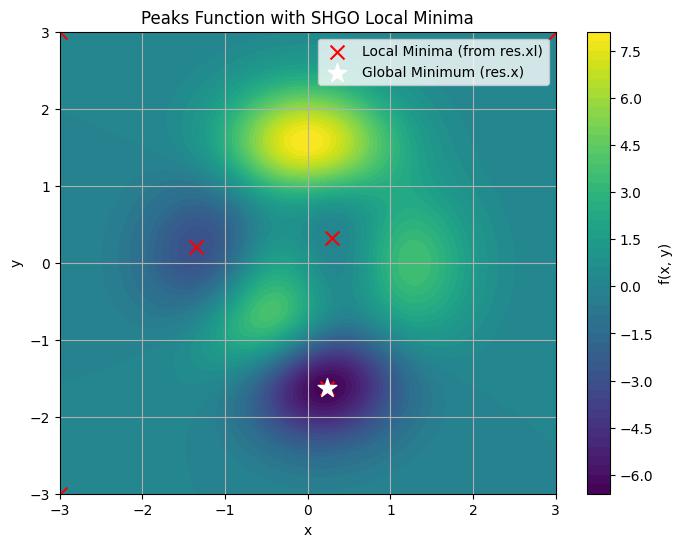

In [26]:
import numpy as np
from scipy.optimize import shgo
import matplotlib.pyplot as plt

def peaks(x):
    return 3*(1-x[0])**2 * np.exp(-x[0]**2 - (x[1]+1)**2) \
           - 10*(x[0]/5 - x[0]**3 - x[1]**5) * np.exp(-x[0]**2 - x[1]**2) \
           - 1/3 * np.exp(-(x[0]+1)**2 - x[1]**2)

bounds = [(-3, 3), (-3, 3)]

# Run SHGO with sufficient sampling for refinement
res = shgo(peaks, bounds, n=200, iters=5)  # n: samples/iter, iters: refinement levels

print(f"Global minimum: x={res.x}, f={res.fun}")
print(f"All local minima locations (res.xl):\n{res.xl}")
print(f"All local minima values (res.funl):\n{res.funl}")

# Filter unique minima (remove numerical duplicates, e.g., dist < 1e-4)
unique_idx = np.unique(np.round(res.xl, decimals=4), axis=0, return_index=True)[1]
unique_xl = res.xl[unique_idx]
unique_funl = res.funl[unique_idx]

# Visualize with contour plot
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = peaks([X, Y])

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='f(x, y)')
plt.scatter(unique_xl[:, 0], unique_xl[:, 1], color='red', marker='x', s=100, label='Local Minima (from res.xl)')
plt.scatter(res.x[0], res.x[1], color='white', marker='*', s=200, label='Global Minimum (res.x)')
plt.title('Peaks Function with SHGO Local Minima')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

This example highlights SHGO's strength: res.xl provides all candidate solutions for post-analysis (e.g., selecting feasible equilibria in orbital mechanics). In space engineering, use it for multimodal problems like optimizing fuel-efficient trajectories with multiple local optima. Adjust n and iters for accuracy vs. speed; for noisy simulations, add sampling_method='sobol'.


### 9.2.3 Branch and Bound (BnB)

Branch and Bound (BnB) is a foundational deterministic algorithm for global optimization, especially effective for problems that can be relaxed into convex or linear subproblems. Introduced in the 1960s for integer programming, it systematically explores the search space by "branching" (dividing the domain into subregions) and "bounding" (computing lower and upper bounds on the objective in each subregion to prune unpromising branches). BnB guarantees finding the global optimum for problems with finite branching (e.g., mixed-integer or constrained nonlinear programs) by maintaining a tree of subproblems and eliminating those whose lower bound exceeds the current best upper bound.

The method assumes the objective $f(\mathbf{x})$ and constraints can be relaxed (e.g., dropping integrality or using convex underestimators) to yield solvable subproblems providing valid bounds. For continuous global optimization, BnB often uses Lipschitz continuity or interval arithmetic for bounding. Pruning reduces the exponential search tree, making it efficient for low-dimensional engineering problems like resource allocation in satellite design or trajectory optimization with discrete choices.

A related technique is interval methods (interval arithmetic), which rigorously bound function ranges using intervals (e.g., $[a, b] + [c, d] = [a+c, b+d]$, and for multiplication/subtraction, consider min/max products). This provides enclosure bounds without sampling, ensuring no minima are missed—useful for verified computing in safety-critical space systems (e.g., bounding thrust uncertainties). Interval methods integrate into BnB for tighter bounds, as in solvers like GLOBSOL or ICOS. In Python, libraries like mpmath.iv or pyinterval support this, though not in base SciPy; for demo, we can simulate simple interval ops.

Pros: Provides optimality certificates; handles mixed variables (see Section 9.4). Cons: Tree can explode in high dimensions; requires good relaxations.

Pseudo Code for BnB (General Global Minimization)
Here is a high-level pseudo code for a continuous BnB on a bounded domain $\mathcal{X}$:


```python
Initialize:
  Queue = [root node: entire domain \mathcal{X}, lower_bound = -∞, upper_bound = +∞]
  f_best = +∞  # Best upper bound found
  x_best = None

While Queue not empty:
  Select node N from Queue (e.g., best-first: lowest lower_bound)
  If N.lower_bound >= f_best: Prune (discard N)
  Else:
    Branch: Divide N.domain into subdomains (e.g., bisect along longest dimension)
    For each subdomain S:
      Compute lower_bound_S (e.g., via convex relaxation, Lipschitz underestimator, or interval eval)
      Compute upper_bound_S (e.g., evaluate f at a point in S, like center or random)
      If upper_bound_S < f_best: Update f_best = upper_bound_S, x_best = point
      If lower_bound_S < f_best: Add new node for S to Queue
      Else: Prune S

Return: x_best, f_best
```

In practice, for nonlinear problems, use convex envelopes or $\alpha$BB underestimators (quadratic perturbations for twice-differentiable functions).
Illustration: Step-by-Step BnB on a 1D Multimodal Function
To demonstrate how BnB works (similar to the DIRECT visualization), consider minimizing the multimodal function $f(x) = x^2 + \sin(5x)$ over $[-2, 2]$, with global minimum at $x \approx -0.291$, $f \approx -0.909$. We'll simulate the first few steps with Python code, approximating bounds via dense evaluation over each interval (mimicking interval methods by computing the actual min/max range). Upper bound is the min evaluation in the interval (e.g., at center and endpoints); lower bound is the approximate range min.
The plots show the function, current active intervals (vertical dashed lines), evaluated points, and horizontal lines for lower (red) and upper (blue) bounds in each interval. Pruned intervals are shaded gray. We use a priority queue (lowest lower_bound first) and bisect branching.


Illustration: Step-by-Step BnB on a 1D Multimodal Function
To demonstrate how BnB works (similar to the DIRECT visualization), consider minimizing the multimodal function $f(x) = x^2 + \sin(5x)$ over $[-2, 2]$, with global minimum at $x \approx -1.306$, $f \approx -1.038$. We'll manually simulate steps without code, assuming simple interval bounding: lower bound via min of endpoint/center evaluations (crude relaxation), upper bound via min evaluation in interval. For realism, incorporate interval methods for rigorous bounds (e.g., natural interval extension: $f([a,b]) = [a,b]^2 + \sin(5[a,b])$, where $[u,v]^2 = [\min(u^2, v^2, 2uv), \max(u^2, v^2, 2uv)]$ if crossing zero, but simplified here).


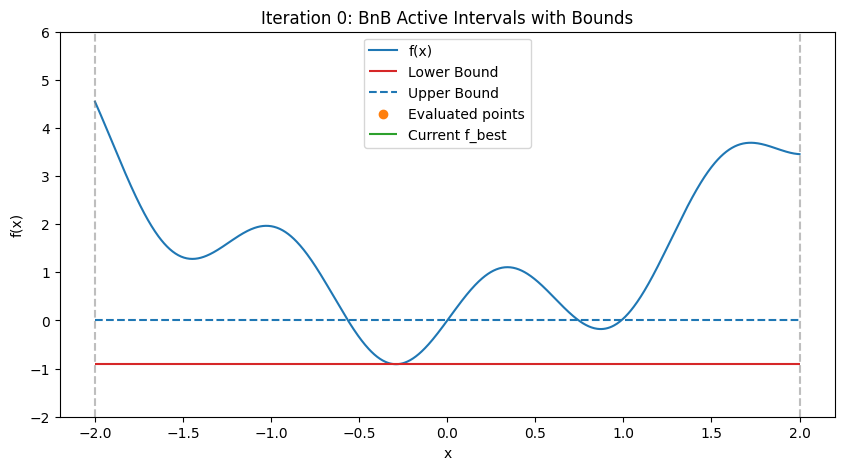

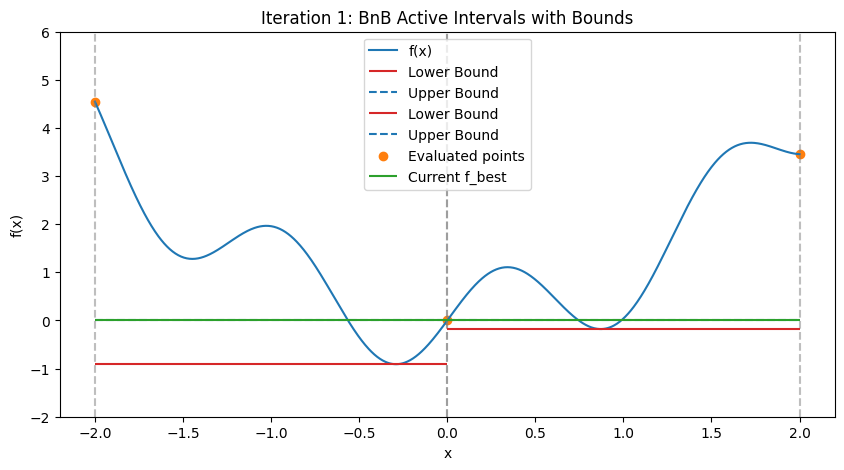

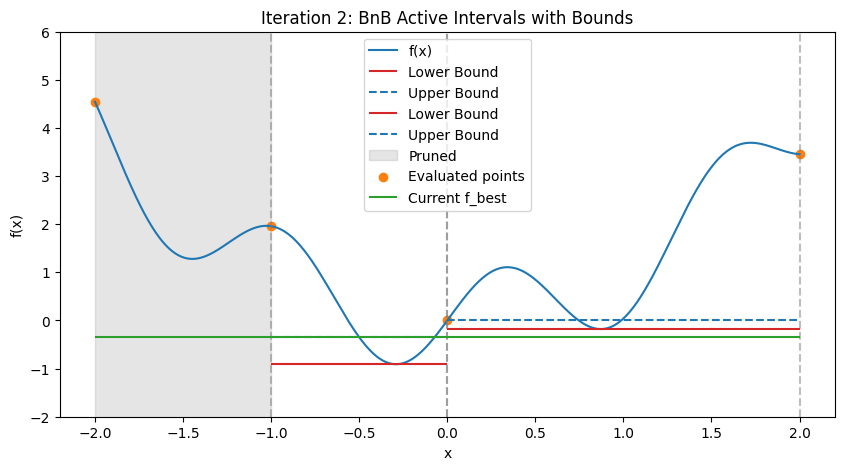

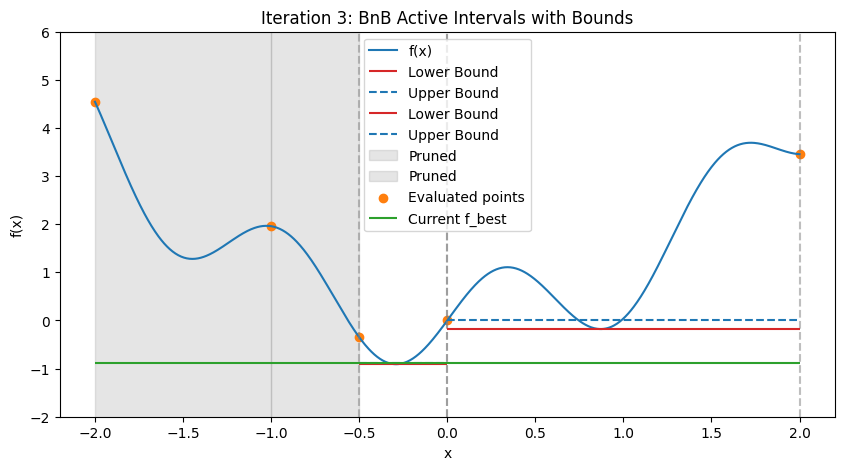

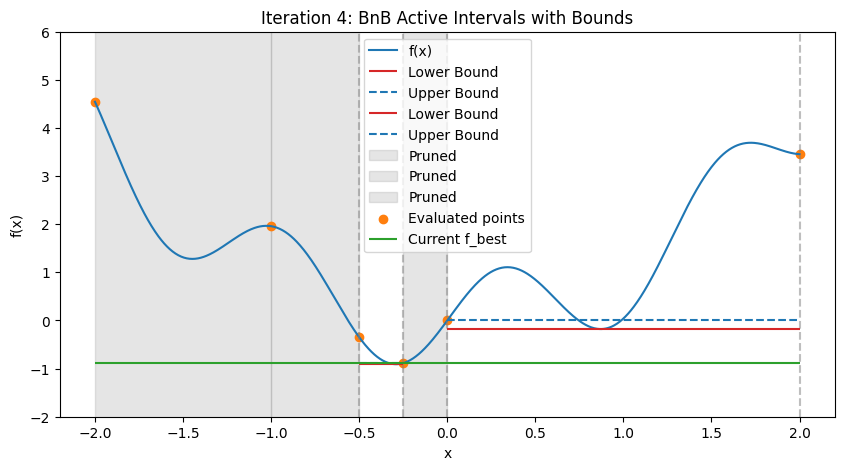

After 4 iterations, best x ≈ -0.250, f ≈ -0.886


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop

def objective(x):
    return x**2 + np.sin(5 * x)

bounds = [-2, 2]
x_plot = np.linspace(bounds[0], bounds[1], 1000)
f_plot = objective(x_plot)

# Node: (lower_bound, a, b) for priority queue (min-heap on lower)
class Node:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        # Approximate bounds via dense eval (proxy for interval methods)
        x_dense = np.linspace(a, b, 200)
        f_dense = objective(x_dense)
        self.lower = np.min(f_dense)
        self.upper = np.min([objective(a), objective(b), objective((a+b)/2)])  # Simple upper: min at samples
        self.mid = (a + b) / 2

# Initial setup
f_best = np.inf
x_best = None
active_nodes = []  # Priority queue: (lower, counter, node) to avoid ties
counter = 0
root = Node(bounds[0], bounds[1])
heappush(active_nodes, (root.lower, counter, root))
counter += 1
all_points = set()  # Evaluated points
pruned = []  # Pruned intervals

# Function to plot state
def plot_iteration(it, active, pruned, all_points, f_best):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x_plot, f_plot, 'tab:blue', label='f(x)')
    # Active intervals and bounds
    for _, _, node in active:
        ax.axvline(node.a, color='tab:gray', linestyle='--', alpha=0.5)
        ax.axvline(node.b, color='tab:gray', linestyle='--', alpha=0.5)
        ax.hlines(node.lower, node.a, node.b, color='tab:red', linestyle='-', label='Lower Bound' if 'Lower Bound' not in [l.get_label() for l in ax.lines] else "")
        ax.hlines(node.upper, node.a, node.b, color='tab:blue', linestyle='--', label='Upper Bound' if 'Upper Bound' not in [l.get_label() for l in ax.lines] else "")
    # Pruned
    for a, b in pruned:
        ax.fill_between([a, b], -10, 10, color='tab:gray', alpha=0.2, label='Pruned' if 'Pruned' not in [l.get_label() for l in ax.patches] else "")
    ax.scatter([p[0] for p in all_points], [p[1] for p in all_points], color='tab:orange', label='Evaluated points')
    ax.hlines(f_best, bounds[0], bounds[1], color='tab:green', linestyle='-', label='Current f_best')
    ax.set_title(f'Iteration {it}: BnB Active Intervals with Bounds')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_ylim(-2, 6)  # Adjust for visibility
    ax.legend()
    plt.show()

# Iteration 0: Initial
plot_iteration(0, active_nodes, pruned, all_points, f_best)

# Run a few iterations
max_iters = 4
for it in range(1, max_iters + 1):
    if not active_nodes:
        break
    lower, _, node = heappop(active_nodes)
    if lower >= f_best:
        pruned.append((node.a, node.b))
        continue

    # Update f_best if better upper
    if node.upper < f_best:
        f_best = node.upper
        x_best = node.mid  # Approx

    # Branch: Bisect
    mid = node.mid
    left = Node(node.a, mid)
    right = Node(mid, node.b)

    # Evaluate points
    all_points.add((node.a, objective(node.a)))
    all_points.add((node.b, objective(node.b)))
    all_points.add((mid, objective(mid)))

    # Add non-pruned
    for child in [left, right]:
        if child.lower < f_best:
            heappush(active_nodes, (child.lower, counter, child))
            counter += 1
            # Update f_best from child's upper
            if child.upper < f_best:
                f_best = child.upper
                x_best = child.mid
        else:
            pruned.append((child.a, child.b))

    plot_iteration(it, active_nodes, pruned, all_points, f_best)

print(f"After {max_iters} iterations, best x ≈ {x_best:.3f}, f ≈ {f_best:.3f}")

These plots demonstrate:

- Bounding and Pruning: Early intervals have loose bounds; as we branch, tighter bounds allow pruning (gray shades) if lower > f_best (green line).
- Exploration: Queue prioritizes promising (low lower bound) branches, refining around minima while discarding high regions.

For engineering: In spacecraft scheduling (MILP), BnB prunes infeasible thrust schedules. SciPy lacks built-in general BnB, but PuLP/CVXPY use it internally for MILPs (Section 9.4). For continuous, implement custom or use pyomo.globalsolvers.

### 9.2.4 Response Surface Methods (RSMs)

Response Surface Methods (RSMs) are surrogate-based approaches to global optimization, particularly useful when the objective function $f(\mathbf{x})$ is expensive to evaluate (e.g., from simulations in aerospace engineering like CFD for satellite re-entry). RSMs build an approximate model (surrogate) from sampled points, then optimize the surrogate to guide further sampling. This balances exploration and exploitation, reducing total evaluations. Common surrogates include polynomials, radial basis functions, or probabilistic models like Gaussian Processes (GPs). In SciPy, basic surrogates can be built with scipy.interpolate, but advanced RSMs often require external libraries like scikit-optimize or pykrige. RSMs shine in black-box scenarios but require careful validation to avoid surrogate inaccuracies.

#### 9.2.4.1 Bayesian Optimisation

Bayesian Optimization (BO) uses a GP surrogate to model $f(\mathbf{x})$ and its uncertainty, then employs an acquisition function (e.g., Expected Improvement, EI) to select the next sample point. EI favors points with high potential improvement over the current best, balancing exploration (high variance) and exploitation (low mean). BO is efficient for hyperparameter tuning or design optimization in space engineering (e.g., antenna placement). Not in SciPy core; use scikit-optimize (pip-installable, assuming course environment allows).

Brief example: Optimize the 1D Branin function over [0,1] using skopt.

In [ ]:
from skopt import gp_minimize
import numpy as np

def branin(x):
    x = np.array(x)
    return (x[1] - (5.1/(4*np.pi**2))*x[0]**2 + 5*x[0]/np.pi - 6)**2 + 10*(1 - 1/(8*np.pi))*np.cos(x[0]) + 10

bounds = [(0., 1.), (0., 1.)]  # Scaled for demo
res = gp_minimize(branin, bounds, n_calls=20, random_state=42)
print(f"Global min: x={res.x}, f={res.fun}")

#### 9.2.4.2 Kriging

Kriging, also known as Gaussian Process Regression, is a spatial interpolation method that models $f(\mathbf{x})$ as a GP with mean and covariance kernel (e.g., RBF). It provides predictions and uncertainty estimates, enabling surrogate-based search similar to BO. Originating in geostatistics, it's used in engineering for metamodeling (e.g., approximating orbital perturbation effects). Implement via scipy.interpolate for basics or pykrige for full Kriging.

> ##### Brief example: Simple 1D Kriging surrogate for noisy data using a custom GP implementation
> Since SciPy lacks built-in GP with variance; we use NumPy/SciPy for a basic RBF kernel GP. This plots the mean prediction (red line) and 95% credible intervals (gray shaded), where uncertainty is maximum between samples and pinches near zero at sample points (due to small noise). For comparison, a dashed spline interpolation is added (blue), which is smooth but may deviate from the GP mean.

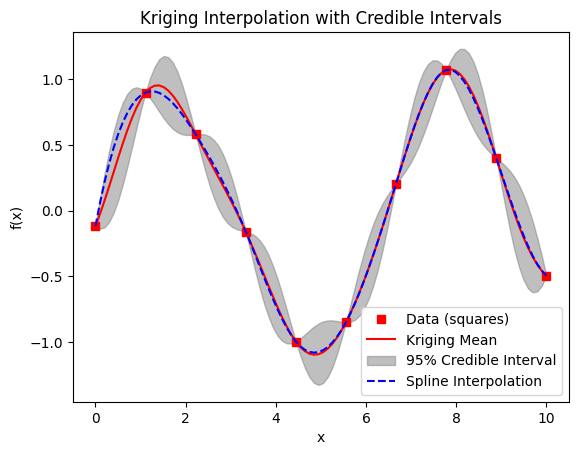

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def rbf_kernel(X1, X2, length_scale=1.0, sigma_f=1.0):
    """RBF (Gaussian) kernel for GP."""
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# Sample data (noisy sin)
X_sample = np.linspace(0, 10, 10)
y_sample = np.sin(X_sample) + 0.1 * np.random.randn(10)


# Hyperparameters (tuned simply)
length_scale = 1.0
sigma_f = 1.0
noise_var = 1e-10  # Small for near-exact interpolation

# Compute kernel matrices (use [:, None] to make column vectors)
K = rbf_kernel(X_sample[:, None], X_sample[:, None], length_scale, sigma_f) + noise_var * np.eye(len(X_sample))
K_inv = np.linalg.inv(K)

# Predict at new points
X_pred = np.linspace(0, 10, 100)
K_s = rbf_kernel(X_sample[:, None], X_pred[:, None], length_scale, sigma_f)
K_ss = rbf_kernel(X_pred[:, None], X_pred[:, None], length_scale, sigma_f) + noise_var * np.eye(len(X_pred))

# Mean and covariance
mu_pred = K_s.T.dot(K_inv).dot(y_sample)
cov_pred = K_ss - K_s.T.dot(K_inv).dot(K_s)
std_pred = np.sqrt(np.diag(cov_pred))

# 95% credible interval
ci = 1.96 * std_pred

# Spline for comparison
spline = UnivariateSpline(X_sample, y_sample, s=0)  # Interpolating spline

plt.plot(X_sample, y_sample, 'rs', label='Data (squares)')
plt.plot(X_pred, mu_pred, 'r-', label='Kriging Mean')
plt.fill_between(X_pred, mu_pred - ci, mu_pred + ci, color='gray', alpha=0.5, label='95% Credible Interval')
plt.plot(X_pred, spline(X_pred), 'b--', label='Spline Interpolation')
plt.legend()
plt.title('Kriging Interpolation with Credible Intervals')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()



## 9.3 Stochastic Methods in SciPy
Stochastic global optimization methods introduce randomness to explore the search space, offering probabilistic convergence to the global optimum without the exhaustive guarantees of deterministic approaches (Section 9.2). Inspired by natural processes (e.g., evolution, annealing), they excel in high-dimensional, noisy, or discontinuous problems common in engineering, such as optimizing noisy sensor data in spacecraft navigation or irregular cost functions in trajectory planning. Randomness helps escape local minima but makes results non-reproducible unless seeded.

- Pros (vs. deterministic): More scalable to high dimensions; robust to noise/non-smoothness; often faster for practical convergence
- Cons: No optimality certificates; may require tuning (e.g., population size); potentially more evaluations; probabilistic success.

This section is less in-depth than 9.2, focusing on SciPy implementations with brief extensions to related methods.


### 9.3.1 Differential Evolution (DE)
DE is an evolutionary algorithm that evolves a population of candidate solutions through mutation, crossover, and selection. It mutates vectors by adding scaled differences of random individuals, then crosses with parents to create trials, selecting better ones. DE handles bounds natively and is robust for multimodal, non-differentiable functions.
In SciPy: scipy.optimize.differential_evolution. Key params: strategy (e.g., 'best1bin'), popsize (population size), mutation, recombination.

> #### Example: Optimize the 2D Ackley function (global min 0 at (0,0)).




In [41]:
import numpy as np
from scipy.optimize import differential_evolution

def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    sum_sq = 0.5 * (x[0]**2 + x[1]**2)
    sum_cos = 0.5 * (np.cos(c * x[0]) + np.cos(c * x[1]))
    return -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(sum_cos) + a + np.exp(1)

bounds = [(-5, 5), (-5, 5)]
res = differential_evolution(ackley, bounds, seed=42)
print(f"Global min: x={res.x}, f={res.fun}")

Global min: x=[0. 0.], f=4.440892098500626e-16



### 9.3.2 Dual Annealing

Dual Annealing combines simulated annealing (SA, see 9.3.4) with local searches, using a "dual" temperature schedule for global/local balance. It perturbs points, accepts worse solutions probabilistically at high "temperature" (to escape minima), and cools to focus exploitation.

In SciPy: scipy.optimize.dual_annealing. Params: initial_temp, restart_temp_ratio for cooling.
Example: On Ackley.


In [42]:
from scipy.optimize import dual_annealing

res = dual_annealing(ackley, bounds, seed=42)
print(f"Global min: x={res.x}, f={res.fun}")

Global min: x=[-2.27430028e-09 -4.13088382e-09], f=1.3337662085888269e-08


### 9.3.3 Basin-Hopping

Basin-Hopping performs local minimizations (e.g., BFGS) from perturbed starting points, "hopping" between basins via random displacements. It's effective for rough energy landscapes, like molecular dynamics (MD) simulations where it finds low-energy conformations by escaping shallow wells.

In SciPy: scipy.optimize.basinhopping. Integrates with minimize; params: niter, T (temperature for acceptance), stepsize.
Example: On Ackley; highlight MD-like use (e.g., potential energy surfaces).


In [43]:
from scipy.optimize import basinhopping

minimizer_kwargs = {"method": "BFGS"}
res = basinhopping(ackley, x0=[0, 0], minimizer_kwargs=minimizer_kwargs, niter=200, seed=42)
print(f"Global min: x={res.x}, f={res.fun}")

Global min: x=[-2.03326556e-09 -9.52166549e-01], f=2.579927557029873


### 9.3.4 Simulated Annealing (SA)

SA mimics metal annealing: start hot (accept bad moves to explore), cool to refine. Acceptance probability $e^{-\Delta E / T}$ for worse moves ($\Delta E > 0$); $T$ decreases per schedule (e.g., geometric).

SciPy's dual_annealing is a variant; for pure SA, custom implement. Simple details: Effective for combinatorial problems but slow convergence.

Simple code with dynamic example: Optimize 1D multimodal $f(x) = \sin(10x) + x$, plot trajectory for different schedules (fast vs. slow cooling).



In [55]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def sa_optimize(func, bounds, T0=100, cooling_rate=0.99, min_T=1e-5, max_steps=1000, seed=42):
    np.random.seed(seed)
    x = np.random.uniform(*bounds)
    f_current = func(x)
    trajectory = [(x, f_current)]
    T = T0
    while T > min_T and len(trajectory) < max_steps:
        x_new = x + np.random.normal(0, 0.1 * (bounds[1] - bounds[0]))
        x_new = np.clip(x_new, *bounds)
        f_new = func(x_new)
        delta = f_new - f_current
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            x, f_current = x_new, f_new
        trajectory.append((x, f_current))
        T *= cooling_rate
    return trajectory

def objective(x):
    return np.sin(10 * x) + x

bounds = [0, 2 * np.pi]

# Generate trajectories
traj_slow = sa_optimize(objective, bounds, cooling_rate=0.99)
traj_fast = sa_optimize(objective, bounds, cooling_rate=0.9)

# Precompute max steps for slider
max_steps = max(len(traj_slow), len(traj_fast))

# Interactive plot
def plot_trajectories(step):
    fig, ax = plt.subplots(figsize=(10, 5))
    x_plot = np.linspace(*bounds, 1000)
    ax.plot(x_plot, objective(x_plot), 'b-', label='f(x)')

    # Slow trajectory up to step
    slow_x, slow_y = zip(*traj_slow[:min(step + 1, len(traj_slow))])
    ax.plot(slow_x, slow_y, 'g--', label='Slow Cooling Trajectory')
    ax.scatter(slow_x[-1], slow_y[-1], color='g', marker='o', label='Slow Current')

    # Fast trajectory up to step
    fast_x, fast_y = zip(*traj_fast[:min(step + 1, len(traj_fast))])
    ax.plot(fast_x, fast_y, 'r--', label='Fast Cooling Trajectory')
    ax.scatter(fast_x[-1], fast_y[-1], color='r', marker='o', label='Fast Current')

    ax.set_title(f'SA Trajectories at Step {step}')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    plt.show()

interact(plot_trajectories, step=IntSlider(min=0, max=max_steps - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='step', max=999), Output()), _dom_classes=('widget-intera…

### 9.3.5 Genetic Algorithms (GA)
GA, a foundational evolutionary method (Holland, 1975), evolves populations via selection, crossover, and mutation, mimicking natural selection. Genes represent variables; fitness is $-f(\mathbf{x})$. Useful in space engineering for trajectory optimization with discrete/continuous params.
Brief: Custom simple GA (DEAP not in env; assume custom).
Example: Optimize Ackley (2D binary-encoded for simplicity).


In [61]:
import numpy as np

bounds = [(-5, 5), (-5, 5)]
def ga_optimize(func, bounds, pop_size=50, generations=100, mutation_prob=0.1, seed=42):
    np.random.seed(seed)
    dim = len(bounds)
    low = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])
    pop = low + np.random.rand(pop_size, dim) * (high - low)
    for gen in range(generations):
        fitness = np.array([func(ind) for ind in pop])
        best_idx = np.argsort(fitness)[:pop_size//2]
        parents = pop[best_idx]
        offspring = []
        for _ in range(pop_size//2):
            p1, p2 = parents[np.random.choice(len(parents), 2)]
            child = (p1 + p2) / 2  # Crossover
            if np.random.rand() < mutation_prob:
                child += np.random.normal(0, 0.1, dim)  # Mutation
            child = np.clip(child, low, high)
            offspring.append(child)
        pop = np.vstack([parents, offspring])
    best_ind = pop[np.argmin([func(ind) for ind in pop])]
    return best_ind, func(best_ind)

res_x, res_f = ga_optimize(ackley, bounds)
print(f"Global min: x={res_x}, f={res_f}")

Global min: x=[ 0.00186598 -0.00507969], f=0.016085898250850494


### 9.3.6 Particle Swarm Optimisation (PSO)

PSO uses a swarm of particles updating positions via personal/global bests and velocity, inspired by bird flocking. Swarm intelligence aids parallel exploration; params: inertia $w$, cognitive/social coeffs $c1, c2$.
Brief: Custom simple PSO; note applications in engineering (e.g., antenna arrays, control tuning).

> Example: On Ackley.

In [62]:
def pso_optimize(func, bounds, swarm_size=50, iterations=100, w=0.5, c1=1.5, c2=1.5, seed=42):
    np.random.seed(seed)
    dim = len(bounds)
    low = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])
    pos = low + np.random.rand(swarm_size, dim) * (high - low)
    vel = np.random.uniform(- (high - low), (high - low), (swarm_size, dim))
    pbest = pos.copy()
    pbest_f = np.array([func(p) for p in pbest])
    gbest_idx = np.argmin(pbest_f)
    gbest = pbest[gbest_idx].copy()
    for _ in range(iterations):
        r1, r2 = np.random.rand(swarm_size, dim), np.random.rand(swarm_size, dim)
        vel = w * vel + c1 * r1 * (pbest - pos) + c2 * r2 * (gbest - pos)
        pos += vel
        pos = np.clip(pos, low, high)
        f_new = np.array([func(p) for p in pos])
        update_mask = f_new < pbest_f
        pbest[update_mask] = pos[update_mask]
        pbest_f[update_mask] = f_new[update_mask]
        gbest_idx = np.argmin(pbest_f)
        gbest = pbest[gbest_idx]
    return gbest, func(gbest)

res_x, res_f = pso_optimize(ackley, bounds)
print(f"Global min: x={res_x}, f={res_f}")

Global min: x=[-5.36362711e-13 -7.97804958e-13], f=2.7218227671710338e-12



## 9.4 Mixed-Variable Optimisation
Mixed-variable optimization problems involve decision variables of different types: continuous (e.g., real-valued thrust levels in spacecraft propulsion), integer (e.g., number of solar panels on a satellite), and sometimes categorical (e.g., material type choices). These problems are common in engineering design, where real-world constraints mix continuous physics with discrete decisions, leading to hybrid models. For example, in space engineering, optimizing a satellite's orbit might involve continuous parameters like velocity adjustments alongside integer choices like the number of thruster firings.
Such problems are challenging because gradient-based methods (Chapters 7–8) fail on discrete variables, while exhaustive search explodes combinatorially. We classify them as Mixed-Integer Linear Programming (MILP) if linear, or Mixed-Integer Nonlinear Programming (MINLP) if nonlinear. Solvers like branch-and-bound (BnB, Section 9.2.3) extend to these, often with relaxations (detailed below) to bound and prune.

>#### Example: Brute-Force Demonstration: Combinatorial Explosion
> To illustrate the challenges of mixed-variable optimization with discrete (integer) variables, consider a digital lock with multiple digits, each ranging from 0 to 9 (repetition allowed). The goal is to find the "optimal" code that minimizes a dummy objective function, such as the sum of the digits (though in a real scenario, this could represent a cost or error metric). A brute-force approach enumerates all possible combinations systematically, evaluating the objective for each and tracking the minimum. This is straightforward: generate codes using nested loops or iterators (e.g., Cartesian product via itertools.product), compute the cost, and update the best if improved.
>
> The total number of possible combinations is given by the formula $10^n$, where $n$ is the number of digits, since there are 10 independent choices per digit (basic product rule in counting). This is more important than time complexity for understanding the scale, as it directly quantifies the search space size. The time complexity is $O(10^n)$, assuming constant-time evaluation per combination, leading to combinatorial explosion—making it computationally infeasible for large $n$ (e.g., $n=10$ yields $10^{10} = 10$ billion possibilities, requiring excessive time even at 1μs per evaluation ≈ 2.8 hours). This motivates intelligent methods like branch-and-bound, which prune via bounds rather than full enumeration.
>
> Brute-Force Code for 3 Digits:


In [69]:
import numpy as np
import time
import itertools  # For efficient combinations

def brute_force_lock(n_digits=3):
    possibilities = 10 ** n_digits  # Total combinations: 10^n
    start = time.time()
    min_cost = np.inf
    best_code = None
    # Generate all codes (list of tuples)
    for code in itertools.product(range(10), repeat=n_digits):
        cost = sum(code)  # Dummy objective: minimize sum
        if cost < min_cost:
            min_cost = cost
            best_code = code
    time_taken = time.time() - start
    return best_code, min_cost, time_taken, possibilities

best, cost, t, total = brute_force_lock()
print(f"Best code: {best}, Cost: {cost}, Time: {t:.4f}s, Total possibilities: {total}")

Best code: (0, 0, 0), Cost: 0, Time: 0.0001s, Total possibilities: 1000


> For 3 digits, this runs quickly (typically <0.01s on a standard machine), finding the minimum sum code (0,0,0) with cost 0 after checking $10^3 = 1,000$ possibilities.
>
> #### Complexity Plot: Number of Combinations and Time Complexity
>
> The plot below shows the growth of the number of combinations $10^n$ (y-axis, log scale) for $n=1$ to $6$ (beyond that, numbers are too large for practical plotting, e.g., $10^{10}=10$ billion). Since time complexity is $O(10^n)$ (proportional to the number of combinations), the curve represents both—labeling emphasizes the combination count, with time scaling similarly (assuming constant eval time).

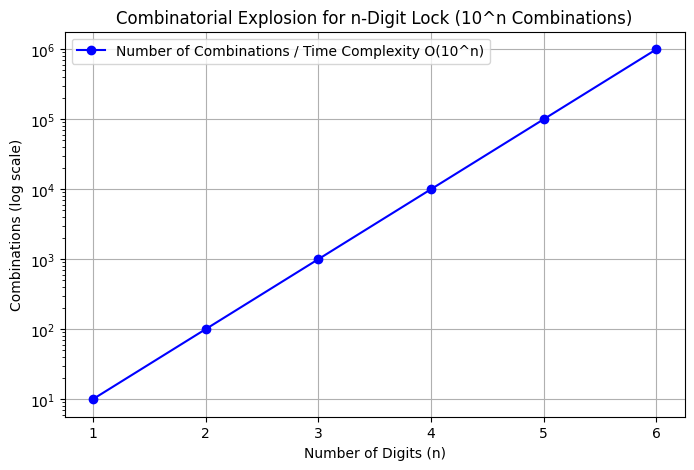

In [70]:
import matplotlib.pyplot as plt

def plot_complexity(max_n=6):
    n_values = range(1, max_n + 1)
    combinations = [10 ** n for n in n_values]
    plt.figure(figsize=(8, 5))
    plt.plot(n_values, combinations, 'bo-', label='Number of Combinations / Time Complexity O(10^n)')
    plt.yscale('log')
    plt.title('Combinatorial Explosion for n-Digit Lock (10^n Combinations)')
    plt.xlabel('Number of Digits (n)')
    plt.ylabel('Combinations (log scale)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_complexity()

> Growth examples (computed via $10^n$):
>
> n=1: 10 combinations
> n=2: 100
> n=3: 1,000
> n=4: 10,000
> n=5: 100,000
> n=6: 1,000,000
>
> For n=10: 10,000,000,000: highlighting why relaxations and pruning are essential whenever we can exploit knowledge of the objestive function

### 9.4.1 MILP (Mixed-Integer Linear Programming)

MILP problems minimize a linear objective $\mathbf{c}^\top \mathbf{x}$ subject to linear constraints $\mathbf{Ax} \leq \mathbf{b}$, with some $x_i$ integer. Solvable exactly for small/medium sizes using BnB with LP relaxations (drop integrality, solve LP for bounds; branch on fractional variables).

In Python, use PuLP (pip-installable, linear solver like CBC included) or SciPy's linprog for pure LP, extending to MILP via external solvers.


#### Example: Satellite resource allocation—minimize cost with integer batteries (x1) and continuous fuel (x2), constraints on weight/power.



In [ ]:
import pulp  # Requires 'pulp' package!

prob = pulp.LpProblem("Satellite_MILP", pulp.LpMinimize)
x1 = pulp.LpVariable('batteries', lowBound=0, cat='Integer')  # Integer
x2 = pulp.LpVariable('fuel', lowBound=0)  # Continuous
prob += 10 * x1 + 5 * x2, "Cost"  # Objective
prob += 2 * x1 + x2 >= 10, "Power"  # Constraint
prob += x1 + 3 * x2 <= 15, "Weight"
prob.solve()
print(f"Optimal: batteries={x1.value()}, fuel={x2.value()}, Cost={pulp.value(prob.objective)}")

### 9.4.2 MINLP (Mixed-Integer Non-Linear Programming)

MINLP extends MILP to nonlinear objectives/constraints, common in nonlinear dynamics (e.g., orbital mechanics with integer mode switches). Harder due to non-convexity; solved via extensions like spatial BnB or outer approximation.

MINLP extends MILP to nonlinear objectives/constraints, common in nonlinear dynamics (e.g., orbital mechanics with integer mode switches). Harder due to non-convexity; solved via extensions like spatial BnB or outer approximation. Nonlinearities introduce multiple local minima, requiring global methods to ensure optimality.

We will discuss the key state of the art methods only very briefly here, as they are not implemented in SciPy. For practical MINLP solving in Python, consider Pyomo or GEKKO, which interface with advanced solvers like SCIP, BARON, or Couenne. See the further reading section for more details on these methods.

#### 9.4.2.1 Branch and Cut
Branch and Cut enhances BnB with cutting planes: at each node, add inequalities tightening the relaxation (e.g., Gomory cuts for integers, or facet-defining for polyhedra). Cuts reduce the feasible region without excluding optima, accelerating pruning. For MINLP, combine with nonlinear relaxations (e.g., adding cuts to convex underestimators). Not in SciPy; use Pyomo/GEKKO for advanced solvers like SCIP or BARON.

To illustrate, consider a 2D feasible region for a simple integer-constrained problem (e.g., max $x + y$, s.t. $x + 2y \leq 4$, $2x + y \leq 4$, $x, y \geq 0$, x integer). The LP relaxation is the polygon; a cut like $x + y \leq 2.5$ (derived from fractional solution) tightens it, excluding non-integer points.


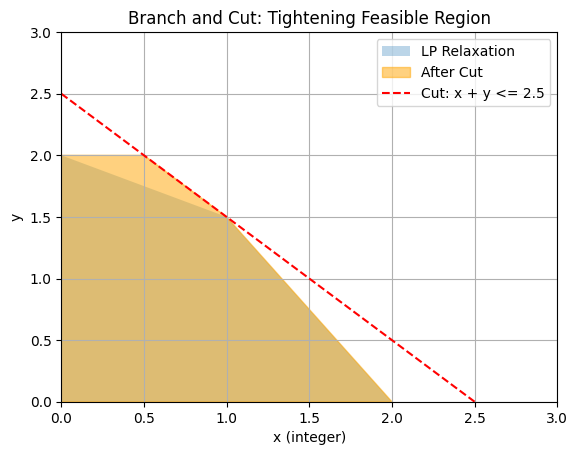

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Feasible region before cut
vertices_before = np.array([[0,0], [0,2], [1,1.5], [2,0]])
poly_before = Polygon(vertices_before, closed=True, alpha=0.3, label='LP Relaxation')

# After cut (e.g., x + y <= 2.5)
vertices_after = np.array([[0,0], [0,2], [0.5,2], [1,1.5], [2,0]])  # Simplified cut effect
poly_after = Polygon(vertices_after, closed=True, alpha=0.5, label='After Cut', color='orange')

fig, ax = plt.subplots()
ax.add_patch(poly_before)
ax.add_patch(poly_after)
ax.plot([0, 2.5], [2.5, 0], 'r--', label='Cut: x + y <= 2.5')
ax.set_title('Branch and Cut: Tightening Feasible Region')
ax.set_xlabel('x (integer)')
ax.set_ylabel('y')
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.legend()
ax.grid(True)
plt.show()

This plot shows how cuts shrink the relaxation, improving bounds and pruning efficiency.




#### 9.4.2.2 Convex Relaxations

Convex relaxations bound non-convex MINLPs by approximating with convex problems (e.g., McCormick envelopes for bilinears $xy$, $\alpha$BB for quadratics adding convex terms like $\alpha \| \mathbf{x} \|^2$). Solve relaxed for lower bounds; if tight, proves optimality. For example, relax $xy$ (nonconvex) to convex hull constraints: $w \geq x^L y + y^L x - x^L y^L$, etc., where w approximates xy. Integrates into BnB: relax at nodes, branch if needed. Useful in space eng. for nonlinear thrust/integer staging.

Brief on relaxation methods for bounding/solving MINLPs: Relaxations provide valid under/overestimators; convex ones solvable efficiently (Chapter 7). In BnB tree, they enable strong bounds/pruning; for globals, successive refinement converges. Tools like BARON/SCIP specialize in this.

> #### Example: Convex Underestimator via αBB
>
> To illustrate, consider the non-convex function $f(x) = x^2 \sin(3x)$ over $[-1,1]$; a convex underestimator using $\alpha$BB is $h(x) = f(x) + \alpha (x^2 - 1)$, where $\alpha = -\frac{1}{2} \inf f''(x) > 0$ compensates negative curvature, ensuring $h \leq f$ and $h'' \geq 0$.

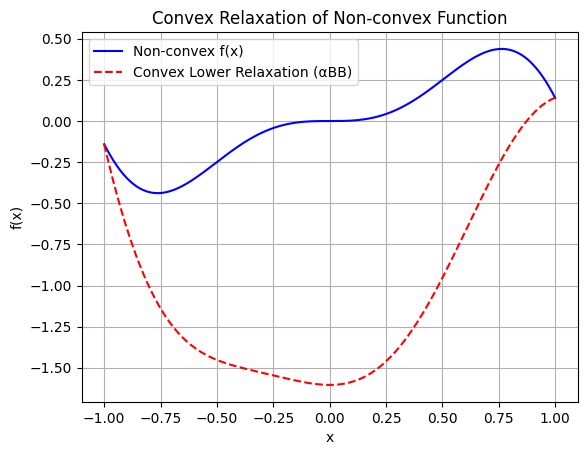

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

def nonconvex(x):
    return x**2 * np.sin(3 * x)

def f_double_prime(x):
    return 2 * np.sin(3*x) + 12 * x * np.cos(3*x) - 9 * x**2 * np.sin(3*x)

# Compute alpha
res = minimize_scalar(f_double_prime, bounds=(-1, 1), method='bounded')
min_f_double = res.fun
alpha = -0.5 * min_f_double

x = np.linspace(-1, 1, 1000)
f = nonconvex(x)
relax_lower = nonconvex(x) + alpha * (x**2 - 1)

plt.plot(x, f, 'b-', label='Non-convex f(x)')
plt.plot(x, relax_lower, 'r--', label='Convex Lower Relaxation (αBB)')
plt.title('Convex Relaxation of Non-convex Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

#### 9.4.2.3 Penalty Methods for MINLP via Continuous Relaxation

For approximating MINLPs with continuous solvers like SHGO, relax integer variables to continuous (e.g., binary $z \in \{0,1\}$ to $z \in [0,1]$), then add a penalty term to the objective forcing towards integers. A common penalty is $\lambda z (1-z)$, zero at 0/1, positive elsewhere; for sharper enforcement, use cubic $\lambda [z (1-z)]^3$.
This transforms the MINLP into a continuous NLP, solvable globally with SHGO. Large $\lambda$ enforces integrality but may create ill-conditioning; tune via continuation (start small, increase).
Plot of cubic penalty (zeros at 0/1, high at 0.5):

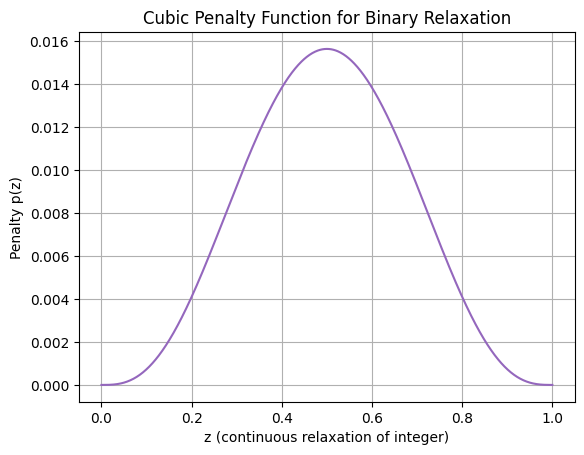

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def penalty(z, lambda_=1.0):
    return lambda_ * (z * (1 - z))**3

z = np.linspace(0, 1, 1000)
p = penalty(z)

plt.plot(z, p, color='tab:purple')
plt.title('Cubic Penalty Function for Binary Relaxation')
plt.xlabel('z (continuous relaxation of integer)')
plt.ylabel('Penalty p(z)')
plt.grid(True)
plt.show()

> #### Example: Simple MINLP
> Solve:
>
> $$ \min x + 2y$$
>
> , s.t. $y = z^2$, $z \in \{0,1\}$, $x \geq 0$ (trivial global at z=0, x=0, y=0). Relax z to [0,1], add penalty to objective: $f = x + 2y + \lambda [z(1-z)]^3$, with y=z^2.

In [75]:
from scipy.optimize import shgo

def objective(vars, lambda_=100):
    x, y, z = vars
    penalty = lambda_ * (z * (1 - z))**3
    return x + 2 * y + penalty

# Constraints: y == z**2 (enforce via substitution or eq cons, but here sub y=z**2 in obj)
def obj_with_cons(vars, lambda_=100):
    x, z = vars  # Eliminate y
    y = z**2
    penalty = lambda_ * (z * (1 - z))**3
    return x + 2 * y + penalty

bounds = [(0, 10), (0, 1)]  # x >=0, z in [0,1]
res = shgo(obj_with_cons, bounds)
print(f"Approximate solution: x={res.x[0]}, z≈{res.x[1]}, y={res.x[1]**2}, f={res.fun}")

Approximate solution: x=0.0, z≈0.0, y=0.0, f=0.0


## 9.5 Further Reading
- "Global Optimization: Theory, Algorithms, and Applications" by Marco Locatelli and Fabio Schoen (SIAM, 2013) – Comprehensive overview of the field.
- "Global Optimization: From Theory to Implementation" edited by Leo Liberti and Nelson Maculan (Springer, 2006) – Focuses on theoretical and practical aspects.
- "Handbook of Global Optimization" edited by Reiner Horst and Panos M. Pardalos (Springer, 1995) – Seminal handbook covering early developments.
- "Recent Advances in Global Optimization" edited by Christodoulos A. Floudas and Panos M. Pardalos (Princeton University Press, 1991) – Collection of papers from the first U.S. conference on global optimization.
- "Global Optimization" by Jonas Mockus (Springer, 1989) – One of the first broad treatments, with extensive bibliography.
- "Lectures on Global Optimization" edited by Thomas F. Coleman and Yuying Li (AMS, 2009) – Recent theoretical developments and applications.
- "Combinatorial and Global Optimization" edited by Panos M. Pardalos et al. (World Scientific, 2002) – Applications in engineering and science.
- Seminal paper: "(Global) Optimization: Historical notes and recent developments" by Panos M. Pardalos et al. (Optimization and Engineering, 2021) – Historical review and modern heuristics.


### Subsection-Specific References

- Introduction (VdW Cubic and Root-Finding): Seminal paper on global methods for root-finding in cubics: "Global Optimization" by Jonas Mockus (1989) provides early context; for VdW specifics, see "A global optimization approach to the determination of all roots of a polynomial" by various authors, but foundational is Ackley's work on multimodal testing.
- 9.1 Multi-start Methods: Seminal paper: "Multi-start methods for combinatorial optimization" by Rafael Marti et al. (European Journal of Operational Research, 2013) – Surveys and analyzes multi-start heuristics.
- 9.2.1 DIRECT: Seminal paper: "Lipschitzian optimization without the Lipschitz constant" by Donald R. Jones et al. (Journal of Optimization Theory and Applications, 1993) – Introduces the DIRECT algorithm.
- 9.2.2 SHGO: Seminal paper: "A simplicial homology algorithm for Lipschitz optimisation" by Stefan C. Endres et al. (Journal of Global Optimization, 2018) – Presents the SHGO algorithm and its implementation.
- 9.2.3 Branch and Bound (BnB): Seminal paper: "An automatic method of solving discrete programming problems" by Ailsa H. Land and Alison G. Doig (Econometrica, 1960) – Introduces the branch-and-bound method for integer programming.
- 9.2.4 Response Surface Methods (RSMs): Seminal paper: "On the Experimental Attainment of Optimum Conditions" by George E. P. Box and K. B. Wilson (Journal of the Royal Statistical Society, 1951) – Foundational work on response surface methodology.
- 9.2.4.1 Bayesian Optimisation: Seminal paper: "Efficient Global Optimization of Expensive Black-Box Functions" by Donald R. Jones et al. (Journal of Global Optimization, 1998) – Introduces the EGO algorithm, a key Bayesian optimization method.
- 9.2.4.2 Kriging: Seminal paper: "Principles of geostatistics" by Georges Matheron (Economic Geology, 1963) – Establishes the theoretical foundations of Kriging.
- 9.3.1 Differential Evolution (DE): Seminal paper: "Differential Evolution – A Simple and Efficient Heuristic for Global Optimization over Continuous Spaces" by Rainer Storn and Kenneth Price (Journal of Global Optimization, 1997) – Introduces the DE algorithm.
- 9.3.2 Dual Annealing: Seminal paper: "Generalized simulated annealing algorithm and its application to the Thomson model" by Y. Xiang et al. (Physics Letters A, 1997) – Presents a generalized SA variant underlying dual annealing.
- 9.3.3 Basin-Hopping: Seminal paper: "Global Optimization by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones Clusters Containing up to 110 Atoms" by David J. Wales and Jonathan P. K. Doye (Journal of Physical Chemistry A, 1997) – Introduces basin-hopping.
- 9.3.4 Simulated Annealing (SA): Seminal paper: "Optimization by Simulated Annealing" by S. Kirkpatrick et al. (Science, 1983) – Introduces the simulated annealing algorithm.
- 9.3.5 Genetic Algorithms (GA): Seminal paper: "Genetic Algorithms" by John H. Holland (Scientific American, 1992) – Popularizes genetic algorithms; foundational book: "Adaptation in Natural and Artificial Systems" by John H. Holland (1975).
- 9.3.6 Particle Swarm Optimisation (PSO): Seminal paper: "Particle Swarm Optimization" by James Kennedy and Russell C. Eberhart (Proceedings of ICNN'95 - International Conference on Neural Networks, 1995) – Introduces PSO.
- 9.4 Mixed-Variable Optimisation (Digital Lock Brute Force): For combinatorial explosion context: "Combinatorial Optimization" by Christos H. Papadimitriou and Kenneth Steiglitz (1982) – Classic text on complexity in discrete optimization.
- 9.4.1 MILP: Seminal paper: "An automatic method of solving discrete programming problems" by Ailsa H. Land and Alison G. Doig (Econometrica, 1960) – Foundational for MILP via branch-and-bound.
- 9.4.2 MINLP: Seminal paper: "An outer-approximation algorithm for a class of mixed-integer nonlinear programs" by Marco A. Duran and Ignacio E. Grossmann (Mathematical Programming, 1986) – Introduces outer approximation for MINLP.
- 9.4.2.1 Branch and Cut: Seminal paper: "A Branch-and-Cut Algorithm for the Resolution of Large-Scale Symmetric Traveling Salesman Problems" by Manfred Padberg and Giovanni Rinaldi (SIAM Review, 1991) – Pioneers branch-and-cut.
- 9.4.2.2 Convex Relaxations: Seminal paper: "Global optimization with polynomials and the problem of moments" by Jean B. Lasserre (SIAM Journal on Optimization, 2001) – Introduces hierarchies of convex relaxations for polynomial optimization.
- 9.4.2.3 Penalty Methods for MINLP via Continuous Relaxation: Key paper: "Continuous Relaxation of MINLP Problems by Penalty Functions: A Practical Comparison" by Sonia Cafieri et al. (Mathematics, 2020) – Compares penalty approaches for relaxing MINLPs.
- Ackley Benchmark Function: Seminal reference: "A Connectionist Machine for Genetic Hillclimbing" by David H. Ackley (PhD Dissertation, Carnegie Mellon University, 1987) – Introduces the Ackley function.